# 1 Configuration

## 1.1 Import Libraries

In [2]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib as matplot
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import graphviz

print("Python ver: {}".format(sys.version))
print("Numpy ver: {}".format(np.__version__))
print("Pandas ver: {}".format(pd.__version__))
print("MatPlotLib ver: {}".format(matplot.__version__))
print("SeaBorn ver: {}".format(sns.__version__))
print("StatsModel ver: {}".format(sm.__version__))
print("Scipy ver: {}".format(scipy.__version__))
print("SkLearn ver: {}".format(sklearn.__version__))
print("Graphviz ver: {}".format(graphviz.__version__))

Python ver: 3.8.5 (default, Jan 27 2021, 15:41:15) 
[GCC 9.3.0]
Numpy ver: 1.19.5
Pandas ver: 1.1.4
MatPlotLib ver: 3.3.3
SeaBorn ver: 0.11.1
StatsModel ver: 0.12.1
Scipy ver: 1.5.4
SkLearn ver: 0.24.1
Graphviz ver: 0.16


In [65]:
def displayPredictors(df):
    print("Number of predictors: {}".format(len(df.columns.values)))
    for i in range(0,len(df.columns.values)):
        print("{}.'{}'".format(i+1,df.columns.values[i]), end=', ')
        
def heatMap(df,max=1,min=-1,triangleMask=False,showDiameter=True,width=11,height=9):
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(width, height))

    # Generate a custom diverging colormap
    cmap = "RdPu"

    # Generate a mask for the upper triangle
    if triangleMask:
        if showDiameter :
            mask = np.triu(np.ones_like(df, dtype=bool),1)
        else:
            mask = np.triu(np.ones_like(df, dtype=bool))
    else:
        mask = None
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df, mask=mask, cmap=cmap, vmax=max, center=(max+min)/2, vmin=min,
                square=True, annot=True, linewidths=.2, cbar_kws={"shrink": .5})

    # Show the plot
    plt.show()
    
    
def scatterPlot(df,xColumn,yColumn,xLabel,yLabel,width=9,height=6,pearson=False):
    fig, ax = plt.subplots(figsize=(width,height))
    
    sns.regplot(y=yColumn, x=xColumn, data=df,ax=ax)
    
    if xLabel:
        plt.xlabel(xLabel)
    if yLabel:
        plt.ylabel(yLabel)
        
    plt.show()
    
    if pearson:
        r,p = scipy.stats.pearsonr(df[xColumn], df[yColumn])
        print("r = {} , p < {}".format(round(r, 3),p))

def pieChart(values,labels,width=7,height=7):
    f, ax = plt.subplots(figsize=(width, height))
    ax = plt.pie(values, labels=labels, wedgeprops={'edgecolor': 'black'}, autopct='%1.f%%', explode=(values*0)+0.05, shadow=True)
    plt.show()
        
def checkColumnsTypes(df):
    types = pd.DataFrame({"Name":df.columns})
    quantitative = df.dtypes[df.dtypes!="object"]
    qualitative = df.dtypes[df.dtypes=="object"]
    types["Type"] = np.where(df[types['Name']].dtypes!="object", "Quantitative", "Qualitative")
    types["isQuantitative"] = np.where(df[types['Name']].dtypes!="object", True, False)
    return types ,types["Type"].value_counts()
    
def checkCorrectness(df,originalLabel,predictedLabel):
    correct = len(df[(df[originalLabel] == df[predictedLabel])])
    incorrect = len(df) - correct
    return (correct,incorrect,(correct*100/(correct+incorrect)))

def findCorrelatedColumns(df,minThreshold):
    corr = df.corr()
    pairs = []

    for i in corr.columns:
        for j in corr[i][abs(corr[i])>=minThreshold].index:
            if i != j:
                pairs.append({"C1":i,"C2":j,"Corr":corr[i][j]})
    return pairs

def findCorrelatedColumns2(df,minThreshold):
    corr = df.corr()
    pairs = []

    for i in corr.columns:
        for j in corr[i][abs(corr[i])>=minThreshold].index:
            if i != j:
                pairs.append(i)
    return pairs

def findHighCorrelation(df,minThreshold,target):
    corr = df.corr()
    pairs = []

    for j in corr[target][abs(corr[target])>=minThreshold].index:
        if target != j:
            pairs.append({"Name":j,"Corr":corr[target][j]})
    return pairs

In [59]:
def checkCorrectness(df,originalLabel,predictedLabel):
    correct = len(df[(df[originalLabel] == df[predictedLabel])])
    incorrect = len(df) - correct
    return (correct,incorrect,(correct*100/(correct+incorrect)))

## 1.2 Pre configurations

In [4]:
import warnings

# Set Seaborn theme
sns.set_theme(color_codes=True)

# Disable warnings
warnings.simplefilter("ignore")

# 2 Data Preparation

## 2.1 Load the data

In [8]:
try:
    data = pd.read_csv("../AimoScoreWeakLinks.csv")
    data = data.drop(columns=["Unnamed: 0"])
except IOError as e:
    print(e)


### Testing and Traing sets

In [14]:
from sklearn.model_selection import train_test_split

trainingPercent = 0.7

y_train,y_test ,X_train, X_test  = train_test_split(data["WeakLinks"], data.drop(columns=["WeakLinks","AimoScore"]), train_size = trainingPercent)

# 3 Create the models

In [18]:
y_test

565             ExcessiveForwardLean
566            RightKneeMovesOutward
295              RightArmFallForward
250               LeftArmFallForward
1959    RightAsymmetricalWeightShift
                    ...             
2070           RightKneeMovesOutward
1504              LeftArmFallForward
192            RightKneeMovesOutward
1938             RightArmFallForward
658           RightShoulderElevation
Name: WeakLinks, Length: 626, dtype: object

## 3.1 Support Vector Machine

### 3.1.1 Linear Kernel

In [68]:
from sklearn.model_selection import GridSearchCV

c = [{'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}]

# 10-fold cross validation (cv=10) 
cv_svm_linear_first = GridSearchCV(SVC(kernel='linear'), c, cv=10)
cv_svm_linear_first.fit(X_train, y_train)

print(cv_svm_linear_first.best_params_)
pd.DataFrame(cv_svm_linear_first.cv_results_)

{'C': 1}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.132973,0.054653,0.014875,0.007371,0.001,{'C': 0.001},0.294521,0.294521,0.294521,0.294521,0.294521,0.294521,0.287671,0.294521,0.294521,0.296552,0.294039,0.002207,7
1,0.097153,0.004398,0.010209,0.000471,0.01,{'C': 0.01},0.410959,0.383562,0.410959,0.397260,0.410959,0.404110,0.410959,0.390411,0.397260,0.413793,0.403023,0.009866,6
2,0.169320,0.069146,0.020266,0.008961,0.1,{'C': 0.1},0.486301,0.472603,0.486301,0.506849,0.493151,0.493151,0.541096,0.465753,0.486301,0.482759,0.491427,0.019693,5
3,0.216819,0.007328,0.024781,0.001622,1,{'C': 1},0.595890,0.575342,0.582192,0.547945,0.589041,0.595890,0.630137,0.575342,0.534247,0.503448,0.572948,0.034106,1
4,0.255128,0.043932,0.022240,0.005678,5,{'C': 5},0.575342,0.568493,0.582192,0.541096,0.568493,0.568493,0.609589,0.595890,0.534247,0.531034,0.567487,0.024476,2
5,0.152691,0.006822,0.010871,0.000663,10,{'C': 10},0.575342,0.568493,0.575342,0.541096,0.534247,0.547945,0.589041,0.582192,0.520548,0.537931,0.557218,0.022385,3
6,0.612067,0.280689,0.009479,0.002103,100,{'C': 100},0.568493,0.561644,0.554795,0.513699,0.527397,0.568493,0.602740,0.609589,0.500000,0.524138,0.553099,0.034751,4


In [69]:
from sklearn.model_selection import GridSearchCV

c = [{'C': [0.5, 0.75, 1, 2 , 3 , 4]}]

# 10-fold cross validation (cv=10) 
cv_svm_linear_second = GridSearchCV(SVC(kernel='linear'), c, cv=10)
cv_svm_linear_second.fit(X_train, y_train)

print(cv_svm_linear_second.best_params_)
pd.DataFrame(cv_svm_linear_second.cv_results_)

{'C': 2}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.098511,0.004893,0.011435,0.000856,0.5,{'C': 0.5},0.554795,0.547945,0.582192,0.534247,0.582192,0.609589,0.609589,0.561644,0.527397,0.531034,0.564062,0.029118,6
1,0.096386,0.007369,0.010960,0.001170,0.75,{'C': 0.75},0.561644,0.561644,0.589041,0.534247,0.589041,0.589041,0.630137,0.561644,0.534247,0.517241,0.566793,0.031860,5
2,0.084656,0.008299,0.009813,0.001255,1,{'C': 1},0.595890,0.575342,0.582192,0.547945,0.589041,0.595890,0.630137,0.575342,0.534247,0.503448,0.572948,0.034106,2
3,0.085540,0.007845,0.008592,0.000099,2,{'C': 2},0.568493,0.582192,0.568493,0.541096,0.595890,0.595890,0.623288,0.582192,0.547945,0.531034,0.573651,0.026812,1
4,0.090294,0.002766,0.008788,0.000482,3,{'C': 3},0.547945,0.589041,0.568493,0.520548,0.602740,0.568493,0.602740,0.595890,0.541096,0.531034,0.566802,0.028922,4
5,0.170880,0.080802,0.016683,0.007405,4,{'C': 4},0.589041,0.568493,0.568493,0.527397,0.582192,0.575342,0.609589,0.609589,0.547945,0.524138,0.570222,0.028431,3


In [70]:
from sklearn.svm import SVC

svm_linear = SVC(C=2, kernel='linear')
svm_linear.fit(X_train, y_train)

print('Number of support vectors: ', svm_linear.support_.size)
svm_linear.support_

Number of support vectors:  1177


array([  40,   41,   73, ..., 1441, 1448, 1455], dtype=int32)

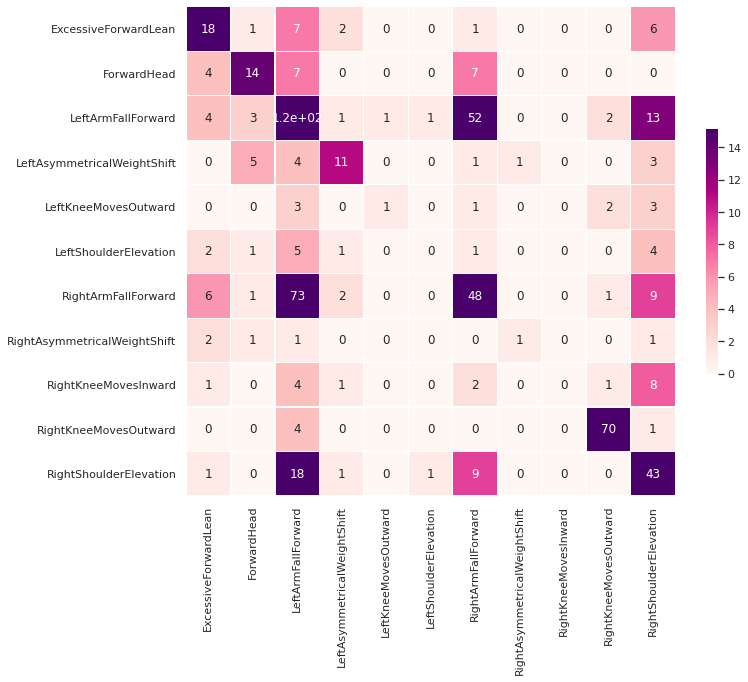

0.5239616613418531

In [73]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_svm_linear = svm_linear.predict(X_test)

confusion_matrix_svm_linear = pd.DataFrame(
    confusion_matrix(y_test, y_pred_svm_linear), 
    index=svm_linear.classes_, columns=svm_linear.classes_)

pivot = np.mean(confusion_matrix_svm_linear.max()/2)
heatMap(confusion_matrix_svm_linear,max=pivot,min=0)

accuracy_svm_linear = classification_report(y_test, y_pred_svm_linear,output_dict=True)["accuracy"]
accuracy_svm_linear

The best accuracy for SVC with linear kernel would be 52% percent which is far from a good one and just 2% higher than a wild guess :D

### 3.1.2 Radial Kernel

In [75]:
from sklearn.model_selection import GridSearchCV


parameters = [{'C': [0.1, 0.5, 1, 2 , 5, 10],'gamma': [0.1,0.2,0.5, 1,2,3,4,5]}]

cv_svm_radial_first = GridSearchCV(SVC(kernel='rbf'), parameters, cv=10)
cv_svm_radial_first.fit(X_train, y_train)

print(cv_svm_radial_first.best_params_)

{'C': 2, 'gamma': 1}


In [77]:
from sklearn.model_selection import GridSearchCV


parameters = [{'C': [ 1.5, 2 , 2.5],'gamma': [0.75, 1, 1.25]}]

cv_svm_radial_second = GridSearchCV(SVC(kernel='rbf'), parameters, cv=10)
cv_svm_radial_second.fit(X_train, y_train)

print(cv_svm_radial_second.best_params_)

{'C': 2, 'gamma': 1}


In [79]:
from sklearn.svm import SVC

svm_radial = SVC(C=2, kernel='rbf',gamma=1)
svm_radial.fit(X_train, y_train)

print('Number of support vectors: ', svm_radial.support_.size)
svm_radial.support_

Number of support vectors:  1286


array([  40,   41,   73, ..., 1448, 1451, 1455], dtype=int32)

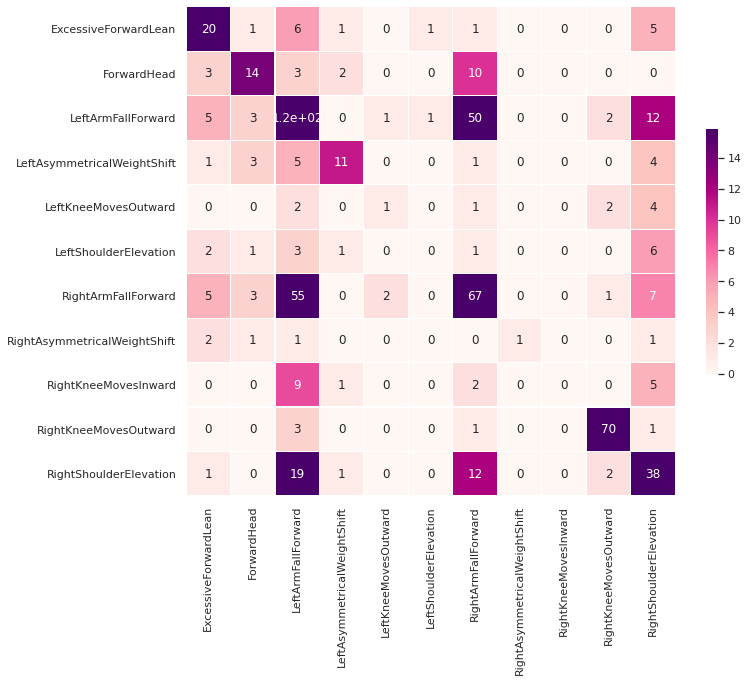

0.5543130990415336

In [80]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_svm_radial = svm_radial.predict(X_test)

confusion_matrix_svm_radial = pd.DataFrame(
    confusion_matrix(y_test, y_pred_svm_radial), 
    index=svm_radial.classes_, columns=svm_radial.classes_)

pivot = np.mean(confusion_matrix_svm_radial.max()/2)
heatMap(confusion_matrix_svm_radial,max=pivot,min=0)

accuracy_svm_radial = classification_report(y_test, y_pred_svm_radial,output_dict=True)["accuracy"]
accuracy_svm_radial

The accuracy of the radial model is 55% which is better than the linear kernel but still far from perfect

### 3.1.3 Polynomial Kernel

In [81]:
from sklearn.model_selection import GridSearchCV


parameters = [{'C': [0.1, 0.5, 1, 2 , 5],'gamma': [0.1,0.5, 1,2,3],'degree':[2,3,4]}]

cv_svm_polynomial_first = GridSearchCV(SVC(kernel='poly'), parameters, cv=10)
cv_svm_polynomial_first.fit(X_train, y_train)

print(cv_svm_polynomial_first.best_params_)

{'C': 0.5, 'degree': 3, 'gamma': 0.5}


In [82]:
from sklearn.model_selection import GridSearchCV


parameters = [{'C': [0.25, 0.4, 0.5, 0.6, 0.75],'gamma': [0.25, 0.4, 0.5, 0.6, 0.75],'degree':[2,3,4]}]

cv_svm_polynomial_second = GridSearchCV(SVC(kernel='poly'), parameters, cv=10)
cv_svm_polynomial_second.fit(X_train, y_train)

print(cv_svm_polynomial_second.best_params_)

{'C': 0.6, 'degree': 3, 'gamma': 0.5}


In [195]:
from sklearn.svm import SVC

svm_polynomial = SVC(C=0.6, kernel='poly', degree=3 ,gamma = 0.5)
svm_polynomial.fit(X_train, y_train)

print('Number of support vectors: ', svm_polynomial.support_.size)
svm_polynomial.support_

Number of support vectors:  1155


array([  40,   41,   73, ..., 1448, 1451, 1455], dtype=int32)

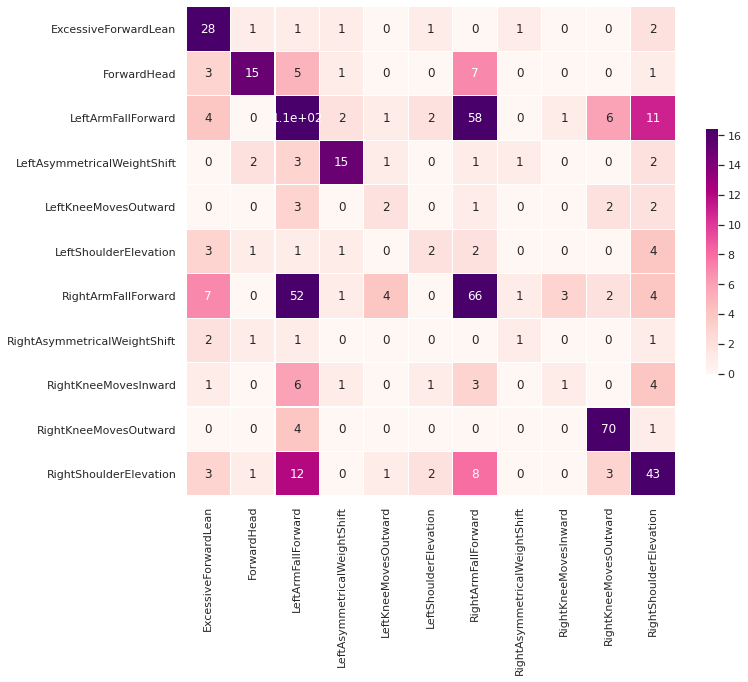

0.5702875399361023

In [196]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_svm_polynomial = svc.predict(X_test)

confusion_matrix_svm_polynomial = pd.DataFrame(
    confusion_matrix(y_test, y_pred_svm_polynomial), 
    index=svm_polynomial.classes_, columns=svm_polynomial.classes_)

pivot = np.mean(confusion_matrix_svm_polynomial.max()/2)
heatMap(confusion_matrix_svm_polynomial,max=pivot,min=0)

accuracy_svm_polynomial = classification_report(y_test, y_pred_svm_polynomial,output_dict=True)["accuracy"]
accuracy_svm_polynomial

## 3.2 Tree Based Approaches

In [92]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold

# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=10, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

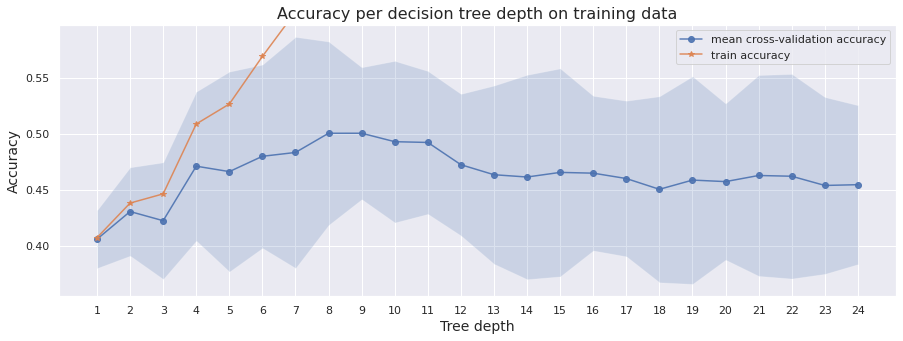

In [94]:
# fitting trees of depth 1 to 24
tree_depths = range(1,25)
cv_scores_mean, cv_scores_std, accuracy_scores = run_cross_validation_on_trees(X_train, y_train, tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(tree_depths, cv_scores_mean, cv_scores_std, accuracy_scores, 
                               'Accuracy per decision tree depth on training data')


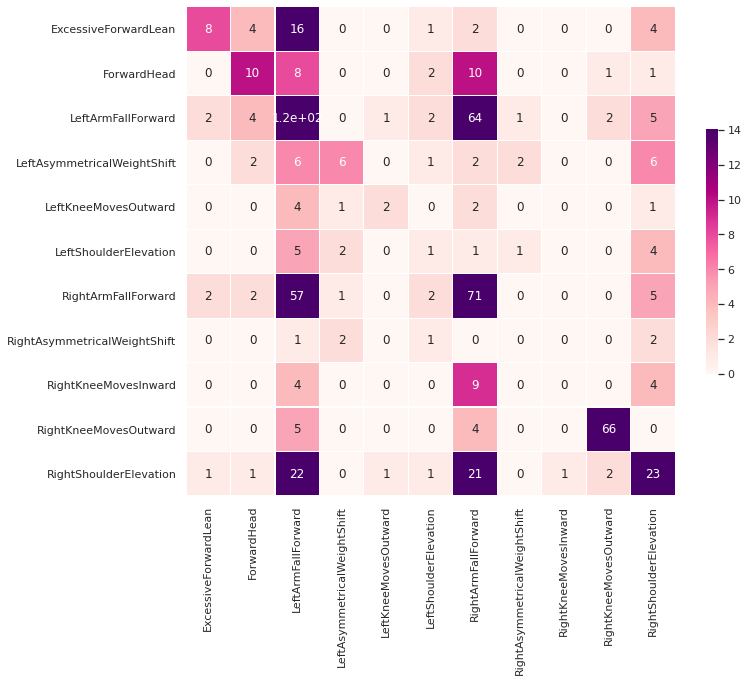

0.48722044728434505

In [98]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth=9)
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)

confusion_matrix_dtc = pd.DataFrame(
    confusion_matrix(y_test, y_pred_dtc), 
    index=dtc.classes_, columns=dtc.classes_)

pivot = np.mean(confusion_matrix_dtc.max()/2)
heatMap(confusion_matrix_dtc,max=pivot,min=0)

accuracy_dtc = classification_report(y_test, y_pred_dtc,output_dict=True)["accuracy"]
accuracy_dtc

## 3.3 Logistic Regression

In [99]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold


# Using 10-fold cross-validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 1)
accuracies = []

for i in range(1, 30):
    model_lr = LogisticRegression(solver='liblinear', C=i, random_state=0)
    cv_scores = cross_val_score(model_lr, X_train, y_train, scoring='accuracy', cv = kfolds)
    accuracies.append(abs(cv_scores.mean()))    

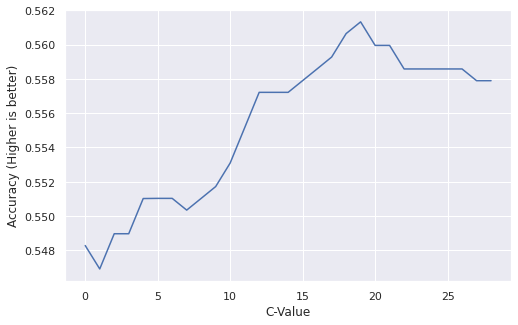

In [100]:
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8,5))

sns.lineplot(data=accuracies,ax=ax)

# Add labels to plot
plt.xlabel("C-Value")
plt.ylabel("Accuracy (Higher is better)")

plt.show()

In [134]:
logistic_regression = LogisticRegression(solver='liblinear', C=18.5, random_state=0)
logistic_regression = logistic_regression.fit(X_train, y_train)


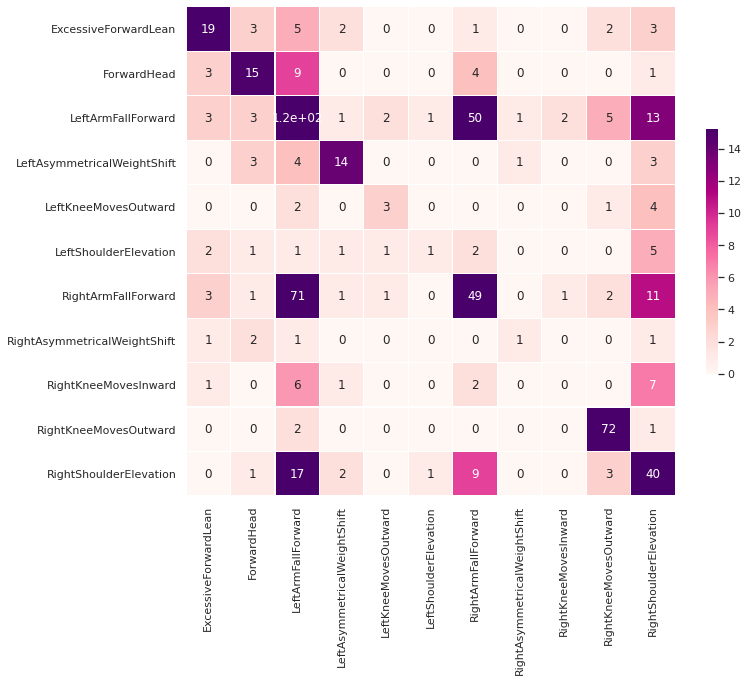

0.5303514376996805

In [135]:
prob = logistic_regression.predict_proba(X_test)

# Find maximum value from probability prediction array
maxValues = pd.DataFrame(prob, columns = range(0,11))

# Dominant WeakLink
y_pred_lr = logistic_regression.classes_[maxValues.idxmax(axis=1, skipna=True)]

confusion_matrix_lr = pd.DataFrame(
    confusion_matrix(y_test, y_pred_lr), 
    index=logistic_regression.classes_, columns=logistic_regression.classes_)

pivot = np.mean(confusion_matrix_lr.max()/2)
heatMap(confusion_matrix_lr,max=pivot,min=0)

accuracy_lr = classification_report(y_test, y_pred_lr,output_dict=True)["accuracy"]
accuracy_lr

## 3.4 Logistic Regression (Polynomial of degree 2)

In [130]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold


# Using 10-fold cross-validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 1)
accuracies = []

for c in range(1, 21):
    model_lr = LogisticRegression(solver='liblinear', C=c, random_state=0)
    pipe = make_pipeline(PolynomialFeatures(degree = 2),model_lr)
    cv_scores = cross_val_score(pipe, X_train, y_train, scoring='accuracy', cv = kfolds)
    accuracies.append(abs(cv_scores.mean())) 
    print('.',end="")


....................

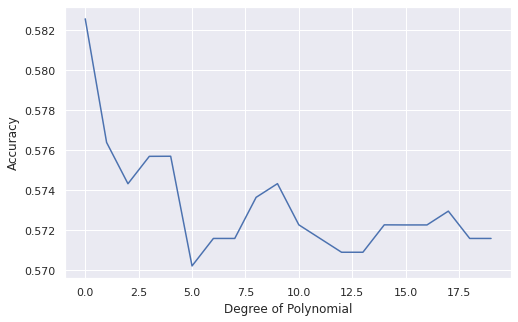

In [131]:
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8,5))

sns.lineplot(data=accuracies,ax=ax)

# Add labels to plot
plt.xlabel("Degree of Polynomial")
plt.ylabel("Accuracy")

plt.show()

In [132]:
logistic_regression_poly = make_pipeline(
    PolynomialFeatures(degree = 2),
    LogisticRegression(solver='liblinear', C=1)
)

logistic_regression_poly = logistic_regression.fit(X_train, y_train)


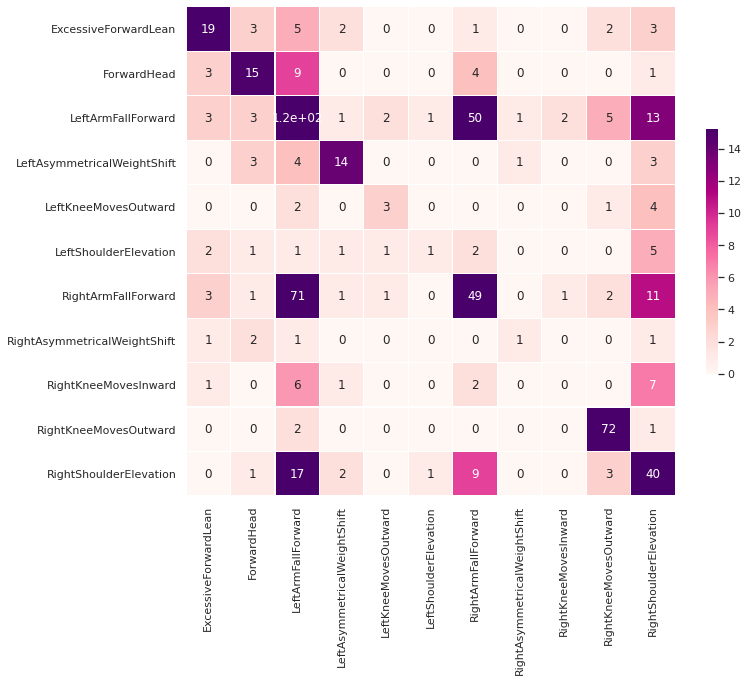

0.5303514376996805

In [137]:
prob = logistic_regression_poly.predict_proba(X_test)

# Find maximum value from probability prediction array
maxValues = pd.DataFrame(prob, columns = range(0,11))

# Dominant WeakLink
y_pred_lr_poly = logistic_regression_poly.classes_[maxValues.idxmax(axis=1, skipna=True)]

confusion_matrix_lr_poly = pd.DataFrame(
    confusion_matrix(y_test, y_pred_lr_poly), 
    index=logistic_regression_poly.classes_, columns=logistic_regression_poly.classes_)

pivot = np.mean(confusion_matrix_lr_poly.max()/2)
heatMap(confusion_matrix_lr_poly,max=pivot,min=0)

accuracy_lr_poly = classification_report(y_test, y_pred_lr_poly,output_dict=True)["accuracy"]
accuracy_lr_poly

## 3.5 K-Nearest Neighbors

In [114]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix,classification_report

# Using 10-fold cross-validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 1)
accuracies = []

for i in range(1, 30):
    model_4 = neighbors.KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(model_4, X_train, y_train, scoring='accuracy', cv = kfolds)
    accuracies.append(abs(cv_scores.mean()))

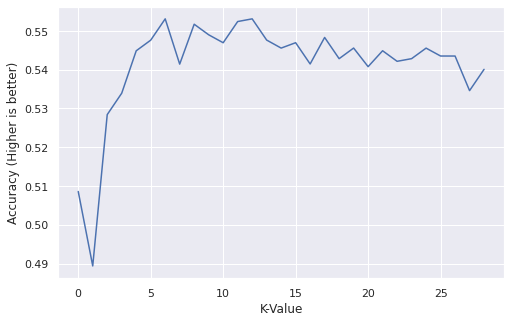

In [115]:
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8,5))

sns.lineplot(data=accuracies,ax=ax)

# Add labels to plot
plt.xlabel("K-Value")
plt.ylabel("Accuracy (Higher is better)")
plt.show()

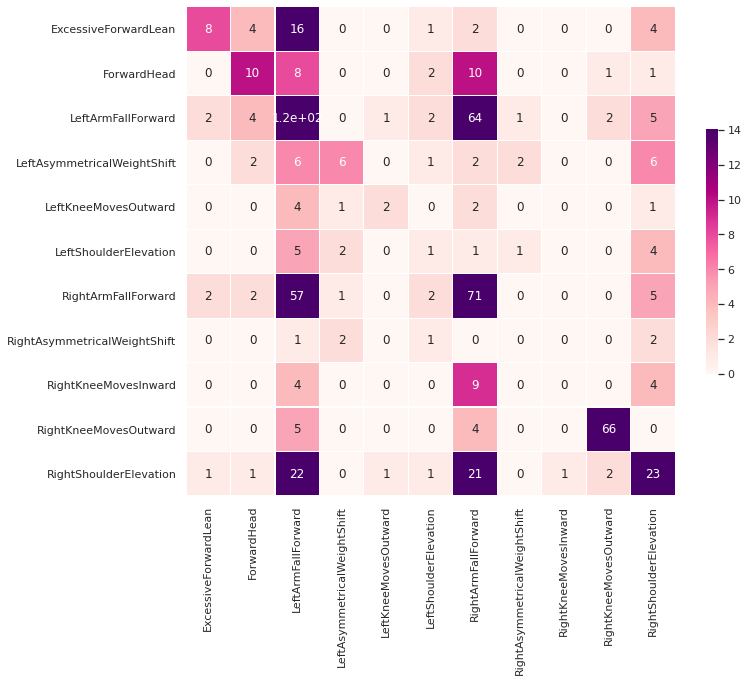

0.5159744408945687

In [120]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix,classification_report

knn = neighbors.KNeighborsClassifier(n_neighbors=6)
knn = knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

confusion_matrix_knn = pd.DataFrame(
    confusion_matrix(y_test, y_pred_knn), 
    index=knn.classes_, columns=knn.classes_)

pivot = np.mean(confusion_matrix_dtc.max()/2)
heatMap(confusion_matrix_dtc,max=pivot,min=0)

accuracy_knn = classification_report(y_test, y_pred_knn,output_dict=True)["accuracy"]
accuracy_knn

# 4 Comparison

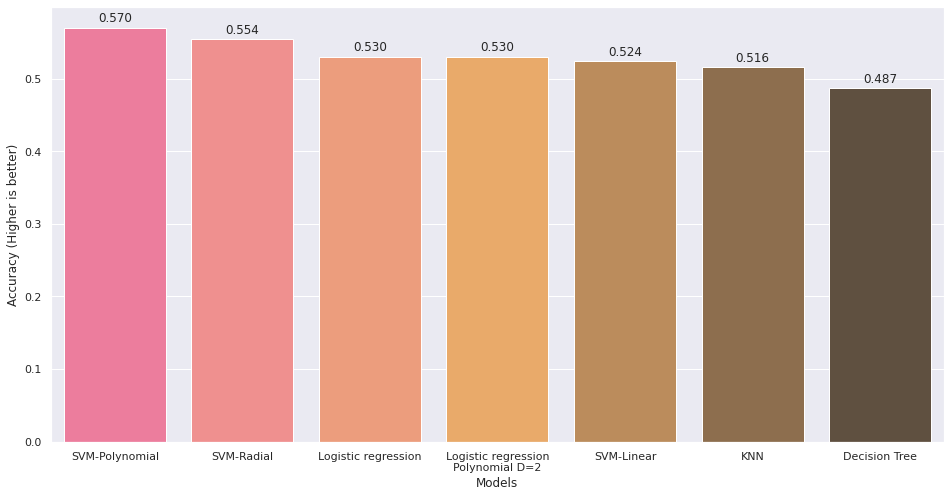

In [197]:
results = pd.DataFrame({
    "Accuracy":[
        accuracy_svm_linear, 
        accuracy_svm_radial, 
        accuracy_svm_polynomial, 
        accuracy_dtc, 
        accuracy_lr,
        accuracy_lr_poly,
        accuracy_knn
    ],
    "Models":[
        "SVM-Linear",
        "SVM-Radial",
        "SVM-Polynomial",
        "Decision Tree",
        "Logistic regression",
        "Logistic regression\nPolynomial D=2",
        "KNN",
    ]
})

results = results.sort_values("Accuracy", ascending=False)

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(16,8))

cplot = sns.barplot(data=results, x="Models", y="Accuracy",ax=ax, palette="spring_d")

for p in cplot.patches:
    cplot.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# Add labels to plot
plt.xlabel("Models")
plt.ylabel("Accuracy (Higher is better)")

plt.show()